## Setup & Imports


In [1]:
!pwd

/Users/michaelnguy/Desktop/capstone/webapp/hashtag_rec


In [2]:
# copy custom scripts from MyDrive to use in Colab
# ref: https://stackoverflow.com/a/74791011
!cp -r /content/drive/MyDrive/hashtag_rec/scripts/. /content/

cp: directory /content does not exist


In [3]:
# !pip install -r requirements.txt

In [4]:
# if running notebook in Google Colab, %load will not work - https://github.com/googlecolab/colabtools/issues/42
# copy paste the contents of constants.py file

# %load constants.py # uncomment this line to load in constants
# data constants
DATA_DIR = "./HARRISON"  # REPLACE THIS with the directory path that you stored the HARRISON dataset in
DATA_LEN = 57383

# file path constants
INDICES_SPLIT_FILE_NAME = "data_indices_split.json"
IMG_PATHS_FILE_NAME = "data_list.txt"
GT_TAGS_FILE_NAME = "tag_list.txt"
EMBEDDINGS_FILE_NAME = "data_embeddings.txt"

# model constants
CLIP_MODEL_NAME = "openai/clip-vit-base-patch32"
VIT_MODEL_NAME = "google/vit-base-patch16-224-in21k"
LLAVA_MODEL_NAME = "llava-hf/llava-1.5-7b-hf"
ST_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

# df column constants
ID_COL = "img_id"
EMB_COL = "emb"
GT_COL = "gt_tags"
PRED_COL = "pred_tags"

# metric constants
ACCURACY = "acc"
PRECISION = "prec"
RECALL = "rec"
SEMANTIC_SIMILARITY = "sim"

In [5]:
import os
import json
import numpy as np
import pandas as pd
import sys

In [6]:
sys.path.append(os.path.join(os.getcwd(), "scripts"))

./HARRISON/data_indices_split.json


In [7]:
from data_utils import load_image_paths, load_image_tags
from eval_utils import evaluate_recommendations
from image_utils import get_image_from_fp, get_image_from_url, get_image_vectorizer_for_recommender
from index import create_index_from_df
from recommenders import (
    ImageIndexTagRecommender,
    TagIndexTagRecommender,
    LlavaTagRecommender,
)

/Users/michaelnguy/miniforge3/envs/playgroundenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data split, image paths, image tags


In [8]:
with open(os.path.join(DATA_DIR, INDICES_SPLIT_FILE_NAME)) as f:
    indices_split = json.load(f)

In [9]:
img_fps = load_image_paths(os.path.join(DATA_DIR, IMG_PATHS_FILE_NAME))

Loading image paths from file: ./HARRISON/data_list.txt
Finished loading 57383 image paths


In [10]:
tags_list = load_image_tags(os.path.join(DATA_DIR, GT_TAGS_FILE_NAME))

Loading image tags from file: ./HARRISON/tag_list.txt
Finished loading tags for 57383 images


## ImageIndex recommender


In [11]:
experiment_name = "clip_unweighted"

### Load embeddings


In [12]:
emb_fp = os.path.join(DATA_DIR, "data_embeddings.txt")
emb_df = pd.read_json(emb_fp, lines=True)
emb_df.shape

(57333, 2)

In [13]:
train_df = emb_df[emb_df[ID_COL].isin(indices_split["train"])]
test_df = emb_df[emb_df[ID_COL].isin(indices_split["test"])]

In [14]:
test_idx_mapping = {i: img_id for i, img_id in enumerate(test_df[ID_COL])}

In [15]:
len(test_df), len(test_idx_mapping)

(500, 500)

### Create index


In [16]:
img_index, train_idx_mapping = create_index_from_df(train_df)

Creating index with vectors of shape: (56333, 512)


### Create recommender


In [17]:
recommender = ImageIndexTagRecommender(
    img_index, train_idx_mapping, tags_list, weight_method="frequency"
)

### Get recommendations


In [18]:
rec_tags = recommender.get_tags_for_image_vector(np.array(test_df[EMB_COL].to_list()))
len(rec_tags)

500

In [19]:
rec_tags[:3]

[['flower', 'yellow', 'purple', 'spring', 'tree'],
 ['vscocam', 'vsco', 'nature', 'sky', 'tree'],
 ['baby', 'instagood', 'cute', 'love', 'family']]

In [20]:
# save recommendations to file
with open(
    os.path.join("recommendations", "test", f"recommendations_{experiment_name}.txt"),
    "w",
) as f:
    for i, (idx, row) in enumerate(test_df.iterrows()):
        img_id = row["img_id"]
        gt_tags = tags_list[img_id]
        pred_tags = rec_tags[i]

        json.dump({"img_id": img_id, "gt_tags": gt_tags, "pred_tags": pred_tags}, f)
        f.write(os.linesep)

### Get recommendations from images

In [19]:
img_vectorizer = get_image_vectorizer_for_recommender()

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

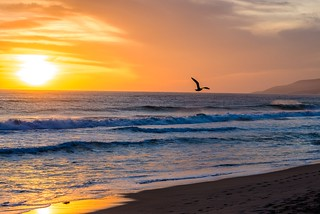

In [21]:
img_url = "https://live.staticflickr.com/7707/16525630273_09bd1f9bf3_n.jpg"
img = get_image_from_url(img_url)
img

In [22]:
recommender.get_tags_for_image(img, img_vectorizer)

[['sunset', 'sea', 'beach', 'landscape', 'nature']]

## TagIndex recommender


In [21]:
experiment_name = "clip_tag_index_unweighted"

### Load embeddings


In [22]:
tag_emb_fp = os.path.join(DATA_DIR, "clip_tag_embs.txt")
tag_emb_df = pd.read_json(tag_emb_fp, lines=True)
tag_emb_df.shape

# tag_emb_df.head()

(997, 3)

### Create index


In [23]:
tag_index, tag_idx_mapping = create_index_from_df(tag_emb_df, id_col="tag_id")

Creating index with vectors of shape: (997, 512)


### Create recommender


In [24]:
idx_tag_mapping = tag_emb_df["tag"].to_dict()
len(idx_tag_mapping)

997

In [25]:
recommender = TagIndexTagRecommender(
    tag_index, tag_idx_mapping, list(idx_tag_mapping.values())
)

### Get recommendations


In [26]:
rec_tags = recommender.get_tags_for_image_vector(np.array(test_df[EMB_COL].to_list()))
len(rec_tags)

500

In [27]:
rec_tags[:3]

[['purple', 'flowerstagram', 'plant', 'garden', 'grass'],
 ['bluesky', 'beautifulday', 'beach', 'beachlife', 'sunnyday'],
 ['holiday', 'vacation', 'sunnyday', 'webstagram', 'instaphoto']]

In [28]:
# save recommendations to file
with open(
    os.path.join("recommendations", "test", f"recommendations_{experiment_name}.txt"),
    "w",
) as f:
    for i, (idx, row) in enumerate(test_df.iterrows()):
        img_id = row["img_id"]
        gt_tags = tags_list[img_id]
        pred_tags = rec_tags[i]

        json.dump({"img_id": img_id, "gt_tags": gt_tags, "pred_tags": pred_tags}, f)
        f.write(os.linesep)

## LLaVa Recommender

NOTE: This recommender makes use of the [LLaVa model](https://huggingface.co/docs/transformers/main/model_doc/llava), which is a multimodal LLM and requires heavy compute resource such as a GPU to run. It also takes more time to produce recommended tags than the other recommenders. This recommender should be used sparingly.

### Create recommender

In [41]:
recommender = LlavaTagRecommender()

Loading llava model...


preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Finished loading llava model


### Get recommendations

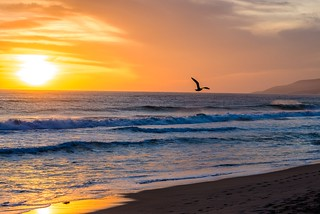

In [21]:
img_url = "https://live.staticflickr.com/7707/16525630273_09bd1f9bf3_n.jpg"
img = get_image_from_url(img_url)
img

In [22]:
recommender.get_tags_for_image(img)

['Sunset', 'Seagull', 'Ocean', 'Waves', 'Beach']

## Evaluate recommendations


In [29]:
from sentence_transformers import SentenceTransformer

In [30]:
st_model = SentenceTransformer(ST_MODEL_NAME)

/Users/michaelnguy/miniforge3/envs/playgroundenv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [31]:
experiment_name = "clip_unweighted"

In [32]:
pred_df = pd.read_json(
    os.path.join("recommendations", "test", f"recommendations_{experiment_name}.txt"),
    lines=True,
)
pred_df.shape

(500, 3)

In [33]:
eval_results = evaluate_recommendations(pred_df, sim_model=st_model)

In [34]:
with open(
    os.path.join("eval_results", "test", f"eval_results_{experiment_name}.json"), "w"
) as f:
    json.dump(eval_results, f, indent=2)

## Visualizations


In [35]:
def graph_metric(metric_name, df):
    df_to_graph = df[df["metric"] == metric_name].copy()
    return (
        alt.Chart(df_to_graph)
        .mark_line()
        .encode(x="k:O", y="value", color="method")
        .properties(title=metric_name, width=300, height=200)
    )

### Load and reformat data


In [36]:
eval_results_dir = os.path.join("eval_results", "test")

In [37]:
eval_results_data = []
for file_name in os.listdir(os.path.join(eval_results_dir)):
    print(file_name)
    fp = os.path.join(eval_results_dir, file_name)

    with open(fp) as f:
        eval_results_json = json.load(f)
    for metric_name, results_dict in eval_results_json.items():
        for k, result in results_dict.items():
            eval_results_data.append(
                {
                    "method": file_name[13:-15],
                    "metric": metric_name,
                    "k": k,
                    "value": result,
                }
            )
len(eval_results_data)

eval_results_clip_unweighted.json


20

In [38]:
eval_results_df = pd.DataFrame(eval_results_data)
eval_results_df.shape

(20, 4)

In [39]:
metric_names = {
    "acc": "Accuracy",
    "rec": "Recall",
    "prec": "Precision",
    "sim": "Semantic Similarity",
}

In [40]:
method_names = {
    "clip_unweighted": "CLIP image embeddings",
    "tag_index_unweighted": "CLIP image-text embeddings",
    "vit_unweighted": "ViT image embeddings",
    "llava_unweighted": "LLaVa",
    "clip_clip_weighted": "CLIP image embeddings",
    "tag_index_clip_weighted": "CLIP image-text embeddings",
    "vit_clip_weighted": "ViT image embeddings",
    "llava_clip_weighted": "LLaVa",
}

In [41]:
eval_results_df["metric"] = eval_results_df["metric"].replace(metric_names)
eval_results_df["method"] = eval_results_df["method"].replace(method_names)

### Graphs


In [42]:
import altair as alt

In [43]:
acc_graph = graph_metric(metric_names["acc"], eval_results_df)
prec_graph = graph_metric(metric_names["prec"], eval_results_df)
rec_graph = graph_metric(metric_names["rec"], eval_results_df)
sim_graph = graph_metric(metric_names["sim"], eval_results_df)

In [44]:
((acc_graph | prec_graph) | rec_graph) | sim_graph

alt.HConcatChart(...)

In [45]:
acc_graph | prec_graph

alt.HConcatChart(...)

In [46]:
rec_graph | sim_graph

alt.HConcatChart(...)

### Tables


In [47]:
from IPython.core.display import display, HTML

/var/folders/lp/k6q1n4l164l7s056_kj52d3c0000gn/T/ipykernel_86660/2058709175.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [48]:
display(
    HTML(
        eval_results_df[eval_results_df["metric"] == metric_names["sim"]]
        .pivot(columns="k", index="method", values="value")
        .to_html(index=True)
    )
)

k,1,2,3,4,5
method,,,,,
clip_,0.631344,0.576225,0.543656,0.523551,0.506207
